In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from math import sqrt, pi,exp,log2
from random import random
from hilbertcurve.hilbertcurve import HilbertCurve

In [34]:
def Im2chaine(image):
    mat=np.asarray(image,)
    n=len(mat)
    chaine=np.zeros(n*n,dtype='int64')
    hilbert_curve=HilbertCurve(int(log2(n)),2)
    for i in range(n):
        for j in range(n):
            chaine[hilbert_curve.distance_from_coordinates([i,j])]=mat[i][j]
    return chaine

def chaine2Im(chaine):
    n=len(chaine)
    m=int(sqrt(n))
    mat=np.zeros((m,m))
    hilbert_curve=HilbertCurve(int(log2(n)),2)
    for i in range(n):
        coor=hilbert_curve.coordinates_from_distance(i)
        mat[coor[0]][coor[1]]=chaine[i]
    return (mat)

def lit_image(nom_image):
    im=Image.open(nom_image)
    return (np.array(im),im.size[0],im.size[1])

def affiche_image(mat_image,titre,show=True):
    plt.title(titre)
    plt.imshow(mat_image,cmap='Greys_r')
    if show:
        plt.show()

def identif_classes(X):
    classes=np.unique(X)
    return(classes)

def bruit_gauss(X,classes,mean,std):
    n=X.shape[0]
    nb_classes=classes.shape[0]
    gauss=[]
    for i in range(nb_classes):
        gauss+=[np.random.normal(mean[i],std[i],n)]
    bruit=np.zeros((nb_classes,n))
    for i in range(nb_classes):
        bruit[i]=np.where(X==classes[i],gauss[i],0)
    return(bruit.sum(axis=0))

def norm_pdf(Y,mu,sig):
    return(np.exp((-(Y-mu)**2)/(2*sig**2))/(sqrt(2*pi)*sig))
def taux_erreur(A,B):
    moy=np.mean(np.abs(A-B)/255)
    return(min(moy,1-moy))

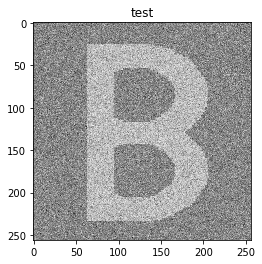

In [16]:
image,m,n=lit_image('./images/beee2.bmp')
image_bruit=bruit_gauss(image,np.array([0,255]),np.array([1,3]),np.array([1,1]))
affiche_image(image_bruit,'test',True)

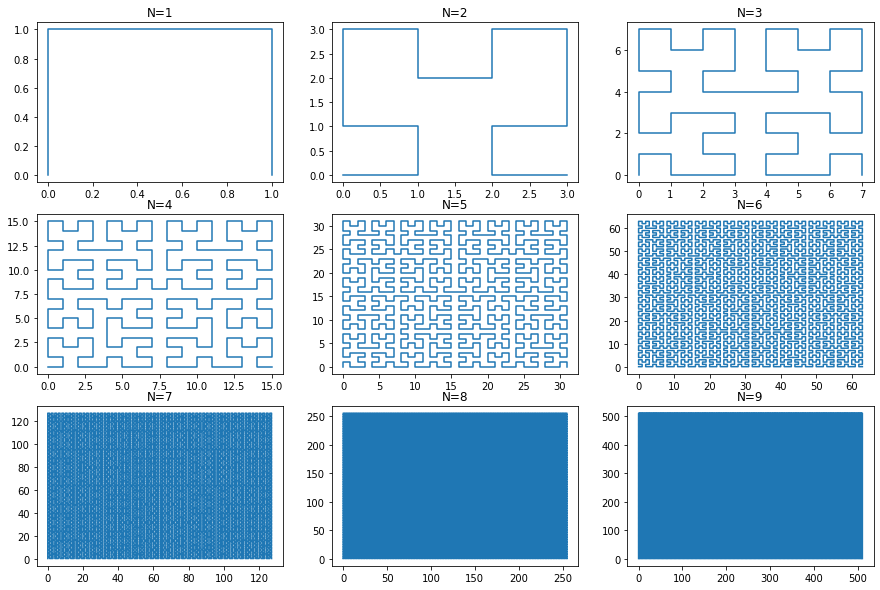

In [18]:
fig=plt.figure(figsize=(15,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    N=2**(i)
    hilbert_curve=HilbertCurve(int(log2(N)),2)
    coords=np.zeros((N**2,2))
    for j in range(N**2):
        coords[j]=hilbert_curve.coordinates_from_distance(j)
    plt.title("N="+str(i))
    plt.plot(coords[:,0],coords[:,1])

In [98]:
def calc_transit_prio2(X,classes):
    n=X.shape[0]
    nb_classes=classes.shape[0]
    index_classes=dict()
    for i in range(nb_classes):
        index_classes[classes[i]]=i
    A=np.zeros((nb_classes,nb_classes))
    x_list=X.tolist()
    for (i,j) in zip(x_list,x_list[1:]):
        A[index_classes[int(i)]][index_classes[int(j)]]+=1
    A=(A.T/A.sum(axis=1)).T
    return(A)

def Mat_f_gauss2(Y,mean,std):
    nb_classes=mean.shape[0]
    n=Y.shape[0]
    Mat_f=np.zeros((nb_classes,n))
    for i in range(nb_classes):
        Mat_f[i]=norm_pdf(Y,mean[i],std[i])
    return(Mat_f)
                   
def forward2_CMC(Mat_f,n,A,p0):
    nb_classes=A.shape[0]
    alpha=np.zeros((nb_classes,n))
    alpha[:,0]=p0*Mat_f[:,0]
    alpha[:,0]=alpha[:,0]/(alpha[:,0].sum())
    for i in range(1,n):
        alpha[:,i]=Mat_f[:,i]*np.transpose(alpha[:,i-1])@A
#         alpha[1][i]=Mat_f[1][i]*np.transpose(alpha[:,i-1])@A[:,1]
        alpha[:,i]=alpha[:,i]/(alpha[:,i].sum())
    return alpha
def backward2_CMC(Mat_f,n,A):
    nb_classes=A.shape[0]
    beta=np.zeros((nb_classes,n))
    beta[:,0]=np.ones(nb_classes)
    beta[:,0]=beta[:,0]/(beta[:,0].sum())
    for i in range(1,n):
        beta[:,i]=Mat_f[:,i]*np.transpose(beta[:,i-1])@A
        #beta[1][i]=Mat_f[1][i]*np.transpose(beta[:,i-1])@A[:,1]
        beta[:,i]=beta[:,i]/(beta[:,i].sum())
    return beta
def MPM_chaines2_CMC(Y,Mat_f,classes,A,p0):
    n=Y.shape[0]
    alpha=forward2_CMC(Mat_f,n,A,p0)
    beta=backward2_CMC(Mat_f,n,A)
    X_apost=np.zeros(n)
    p=alpha*beta
    classes_pmax=np.argmax(p,axis=0)
    return classes[classes_pmax]

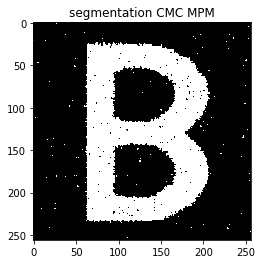

In [100]:
image,m,n=lit_image('./images/beee2.bmp')
image_chaine=Im2chaine(image)
classes=identif_classes(image)
bruit=np.array([1,3])
std=np.array([1,1])
p0=np.array([0.5,0.5])
image_bruite=bruit_gauss(image_chaine,classes,bruit,std)
A=calc_transit_prio2(image_chaine,classes)
Mat_f=Mat_f_gauss2(image_bruite,bruit,std)
image_segmente=MPM_chaines2_CMC(image_bruite,Mat_f,classes,A,p0)
affiche_image(chaine2Im(image_segmente),'segmentation CMC MPM')